In [ ]:
import os
import shutil
from tqdm.auto import tqdm
import tensorflow as tf
from PIL import UnidentifiedImageError
from tensorflow.keras import layers, initializers, regularizers, constraints, activations,models
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.metrics import Precision, Recall,F1Score


2.15.0


In [ ]:


def parse_pts_and_label(filename):
    with open(filename) as file:
        lines = file.readlines()
        label = np.float32( int(lines[-1].split(': ')[1].strip()))  
        points_data = lines[3:-2]
        points = [tuple(map(float, p.strip().split())) for p in points_data]
        points = np.array(points, dtype=np.float32)[36:48] 
    return points, label

def load_image_and_landmarks(filepath):
    image_path = filepath
    pts_path = filepath.replace('.jpg', '.pts')  

    image = Image.open(image_path)
    original_width, original_height = image.size
    image = image.resize((128, 128)).convert('L') 
    image = np.array(image, dtype=np.float32) / 255.0  
    image = np.expand_dims(image, axis=-1)

    points, label = parse_pts_and_label(pts_path)
    points[:, 0] /= original_width 
    points[:, 1] /= original_height  
    points = points.flatten() 

    return image, points, label

def load_data(directory):
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]
    images, points, labels = [], [], []
    count=0
    for filepath in file_paths:
        try:
            img, pts, label = load_image_and_landmarks(filepath)
            images.append(img)
            points.append(pts)
            labels.append(label)
            count+=1
            print(f"Procesando: {count} - {os.path.basename(filepath)}")
        except Exception as e:
            print(f"Error al procesar {filepath}: {str(e)}")

    return np.array(images), np.array(points), np.array(labels)


nme='/content/dataset'

# Cargar datos
nme_images, nme_points, nme_labels = load_data(nme)
nme_dataset = tf.data.Dataset.from_tensor_slices((nme_images, {'output_regressor': nme_points, 'output_classifier': nme_labels}))
size=8
nme_dataset = nme_dataset.batch(size).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
model = tf.keras.models.load_model('/content/drive/Othercomputers/My Laptop/Tesis Marco/ResNeXt_50_Modelo_128x128_vf-28.2')

In [ ]:

optimizer= tf.keras.optimizers.AdamW()

model.compile(
    optimizer= optimizer,  
    loss={
        'output_classifier': 'binary_crossentropy',
        'output_regressor': 'mean_squared_error'  
    },
    metrics={
        'output_classifier': [
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score')
        ],
        'output_regressor': [
            'mse',
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ]
    }
)

In [ ]:



def euclidean_distance(points1, points2):
    return np.linalg.norm(points1 - points2, axis=1)

# Calcular el NME
errors = []
for batch in nme_dataset:
    images, labels = batch
    true_landmarks = labels['output_regressor']

    if isinstance(true_landmarks, tf.Tensor):
        true_landmarks = true_landmarks.numpy()

    predictions = model.predict(images)['output_regressor']  

    for true, pred in zip(true_landmarks, predictions):
        left_eye = true[0:2]  
        right_eye = true[18:20]

        d = euclidean_distance(np.array([left_eye]), np.array([right_eye]))[0]
        true_points = true.reshape(-1, 2)
        pred_points = pred.reshape(-1, 2)
        point_errors = euclidean_distance(true_points, pred_points)  
        mean_error = np.mean(point_errors)

        normalized_error = mean_error / d
        errors.append(normalized_error)

# Calcular el error medio normalizado
mean_nme = np.mean(errors)
print(f"Mean Normalized Error: {mean_nme}")

print("Estadísticas de errores:")
print("Mínimo:", np.min(errors))
print("Máximo:", np.max(errors))
print("Media:", np.mean(errors))


In [ ]:

max_error = np.max(errors)
error_thresholds = np.linspace(0, max_error, 56)

errors_array = np.array(errors) 
ced_values = [(errors_array <= threshold).mean() for threshold in error_thresholds]

# Calcular el Área bajo la Curva (AUC)
auc = np.trapz(ced_values, error_thresholds)
print(f"Área bajo la curva (AUC): {auc}")


# Definir un umbral de fallo 
failure_threshold = 0.10
print(f"Threshold de fallo fijo: {failure_threshold}")

# Calcular el failure rate
failure_rate = np.mean(np.array(errors) > failure_threshold)
print(f"Failure Rate: {failure_rate * 100:.2f}%")

# CED
plt.figure(figsize=(10, 5))
plt.plot(error_thresholds, ced_values, linestyle='-', markersize=4, markerfacecolor='blue')
plt.axvline(x=failure_threshold, color='red', linestyle='--', label=f'Failure Threshold: {failure_threshold:.2f}')
plt.title('Distribución Acumulativa de Errores (CED)')
plt.xlabel('Error Normalizado con distancia "Intra-Ocular"')
plt.ylabel('Número de Imágenes (%)')
plt.grid(True)
plt.legend()
plt.show()


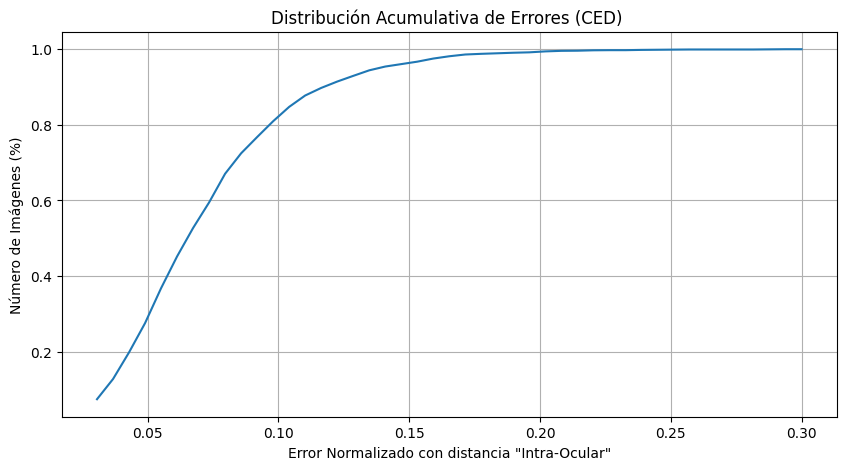

In [ ]:

failure_threshold = 0.10
# Ajustar rango de error thresholds hasta 0.15
error_thresholds = np.linspace(0, 0.30, 50)  # Rango desde 0 hasta 0.15

# Vectorización para cálculo de CED hasta el umbral
errors_array = np.array(errors)  # Convertir a NumPy array si aún no lo es
ced_values = [(errors_array <= threshold).mean() for threshold in error_thresholds]
# Omitir los primeros 4 valores de ced_values y sus correspondientes umbrales
error_thresholds = error_thresholds[5:]
ced_values = ced_values[5:]

# Graficar la CED limitada hasta el umbral de 0.15
plt.figure(figsize=(10, 5))
plt.plot(error_thresholds, ced_values, linestyle='-', markersize=4, markerfacecolor='blue')
plt.title('Distribución Acumulativa de Errores (CED) ')
plt.xlabel('Error Normalizado con distancia "Intra-Ocular"')
plt.ylabel('Número de Imágenes (%)')
plt.grid(True)
plt.show()
